This study tries to predict animal face use 4 different algorithms:
1. Logistic regression classification
1. SVM (Support Vector Machine) classification
1. Random forest classification
1. Decision tree classification


* The dataset contains 3 animal: cat, dog, and wild
* Source dataset: https://www.kaggle.com/andrewmvd/animal-faces

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import matplotlib.image as implt
from PIL import Image 
import seaborn as sns
import cv2 as cs2
import os

import warnings
warnings.filterwarnings('ignore')

In [14]:
## import Keras and its module for image processing and model building
from tensorflow import keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

In [15]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

'#copy the Xception models\n!cp ../input/keras-pretrained-models/xception* ~/.keras/models/\n#show\n!ls ~/.keras/models'

In [ ]:
%%cmd
mkdir input\keras-pretrained-models
copy C:\Users\Pedro\.keras\models\xception_weights_tf_dim_ordering_tf_kernels.h5 input\keras-pretrained-models
dir input\keras-pretrained-models

In [17]:
train_path = "input/animal-faces/afhq/train"
test_path = "input/animal-faces/afhq/val"

train_cat = "input/animal-faces/afhq/train/cat"
train_dog = "input/animal-faces/afhq/train/dog"
train_wild = "input/animal-faces/afhq/train/wild"

test_cat = "input/animal-faces/afhq/val/cat"
test_dog = "input/animal-faces/afhq/val/dog"
test_wild = "input/animal-faces/afhq/val/wild"

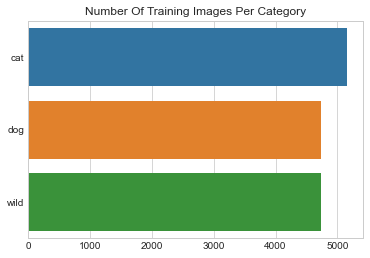

In [18]:
# VISUALIZATION
category_names = os.listdir(train_path) # output: ['cat', 'dog','wild']
nb_categories = len(category_names) # output: 3
train_images = []

for category in category_names:
    folder = train_path + "/" + category
    train_images.append(len(os.listdir(folder)))

sns.barplot(y=category_names, x=train_images).set_title("Number Of Training Images Per Category");

image shape:  (512, 512, 3)
Train Cat Image


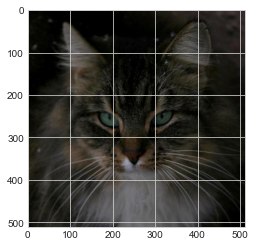

Train Dog Image


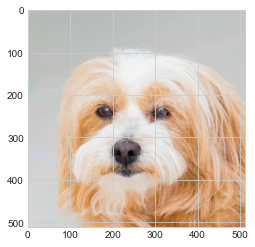

Train Wild Image


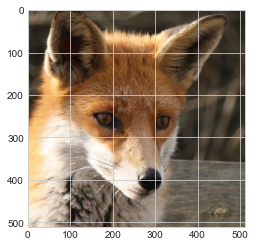

In [20]:
img = load_img('input/animal-faces/afhq/train/cat/flickr_cat_000002.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array 
print('image shape: ', x.shape)

print('Train Cat Image')
plt.imshow(img)
plt.show()


img = load_img('input/animal-faces/afhq/train/dog/flickr_dog_000002.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array 
print('Train Dog Image')
plt.imshow(img)
plt.show()


img = load_img('input/animal-faces/afhq/train/wild/flickr_wild_000002.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array 
print('Train Wild Image')
plt.imshow(img)
plt.show()



# Processing Dataset 
Now we need to modify images. The dataset contains different sizes of RGB color images. 
1. we should resize all the images, 
2. convert images to grayscale (only one dimension), while RBF image has three and helps you to avoid false classification and complexities.


In [21]:
img_size = 50
cat_train = []
dog_train = []
wild_train = []
label = []

for i in os.listdir(train_cat): # all train cat images
    if os.path.isfile(train_path + "/cat/" + i): # check image in file
        cat = Image.open(train_path + "/cat/" + i).convert("L") # converting grey scale 
        cat = cat.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        cat = np.asarray(cat)/255 # bit format
        cat_train.append(cat)
        label.append(0)
        
for i in os.listdir(train_dog): # all train dog images
    if os.path.isfile(train_path + "/dog/" + i): # check image in file
        dog = Image.open(train_path + "/dog/" + i).convert("L") # converting grey scale 
        dog = dog.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        dog = np.asarray(dog)/255 # bit format
        dog_train.append(dog)
        label.append(1)
        
        
for i in os.listdir(train_wild): # all train wild images
    if os.path.isfile(train_path + "/wild/" + i): # check image in file
        wild = Image.open(train_path + "/wild/" + i).convert("L") # converting grey scale 
        wild = wild.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        wild = np.asarray(wild)/255 # bit format
        wild_train.append(wild)
        label.append(2)

In [22]:
x_train = np.concatenate((cat_train,dog_train,wild_train),axis=0) # training dataset
x_train_label = np.asarray(label) # label array containing 0, 1, and 2
x_train_label = x_train_label.reshape(x_train_label.shape[0],1)

print("cat:",np.shape(cat_train) , "dog:",np.shape(dog_train), "wild:",np.shape(wild_train))
print("train_dataset:",np.shape(x_train), "train_values:",np.shape(x_train_label))

cat: (5153, 50, 50) dog: (4739, 50, 50) wild: (4738, 50, 50)
train_dataset: (14630, 50, 50) train_values: (14630, 1)


[0]


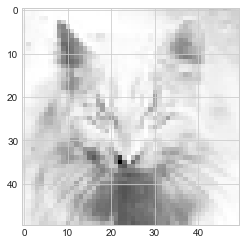

In [23]:
# Visualizing Training data
print(x_train_label[0])
plt.imshow(cat_train[0])

[0]


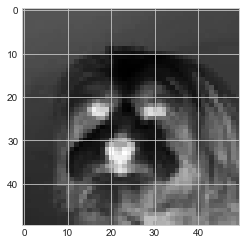

In [24]:
# Visualizing Training data
print(x_train_label[1])
plt.imshow(dog_train[0])

[0]


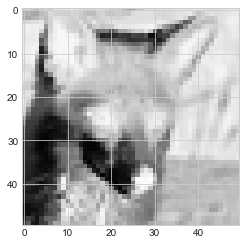

In [25]:
# Visualizing Training data
print(x_train_label[2])
plt.imshow(wild_train[0])

Scaling down the train set and test set images:


1. cat: (5153, 50, 50) dog: (4739, 50, 50) wild: (4738, 50, 50)
1. train_dataset: (14630, 50, 50) train_values: (14630, 1)
1. test_dataset: (1500, 50, 50) test_values: (1500, 1)
1. label 1 for cat, label 2 for dog and label 3 for wild

In [26]:
img_size = 50
cat_test = []
dog_test = []
wild_test = []
label = []

for i in os.listdir(test_cat): # all test cat images
    if os.path.isfile(test_path + "/cat/" + i): # check image in file
        cat = Image.open(test_path + "/cat/" + i).convert("L") # converting grey scale 
        cat = cat.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        cat = np.asarray(cat)/255 # bit format
        cat_test.append(cat)
        label.append(0)
        
for i in os.listdir(test_dog): # all test dog images
    if os.path.isfile(test_path + "/dog/" + i): # check image in file
        dog = Image.open(test_path + "/dog/" + i).convert("L") # converting grey scale 
        dog = dog.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        dog = np.asarray(dog)/255 # bit format
        dog_test.append(dog)
        label.append(1)
        
        
for i in os.listdir(test_wild): # all test wild images
    if os.path.isfile(test_path + "/wild/" + i): # check image in file
        wild = Image.open(test_path + "/wild/" + i).convert("L") # converting grey scale 
        wild = wild.resize((img_size,img_size), Image.ANTIALIAS) # resizing to 50,50
        wild = np.asarray(wild)/255 # bit format
        wild_test.append(wild)
        label.append(2)

In [27]:
x_test = np.concatenate((cat_test,dog_test,wild_test),axis=0) # training dataset
x_test_label = np.asarray(label) # label array containing 0, 1, and 2
x_test_label = x_test_label.reshape(x_test_label.shape[0],1)

print("cat:",np.shape(cat_test) , "dog:",np.shape(dog_test), "wild:",np.shape(wild_test))
print("test_dataset:",np.shape(x_test), "test_values:",np.shape(x_test_label))

cat: (500, 50, 50) dog: (500, 50, 50) wild: (500, 50, 50)
test_dataset: (1500, 50, 50) test_values: (1500, 1)


[0]


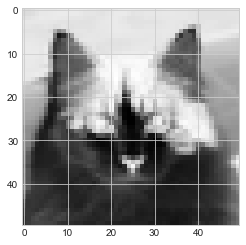

In [28]:
# Visualizing Training data
print(x_test_label[0])
plt.imshow(cat_test[0])

[0]


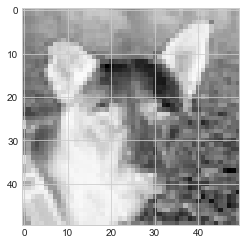

In [29]:
# Visualizing Training data
print(x_test_label[0])
plt.imshow(dog_test[0])

[0]


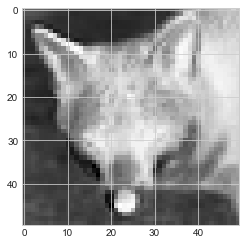

In [30]:
# Visualizing Training data
print(x_test_label[0])
plt.imshow(wild_test[0])

We combine image strings and tags and flatten 'x':

In [31]:
x = np.concatenate((x_train,x_test),axis=0) # counttrain_data

y = np.concatenate((x_train_label,x_test_label),axis=0) # count:  test_data
x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # flatten 3D image array to 2D
print("images:",np.shape(x), "labels:",np.shape(y))

images: (16130, 2500) labels: (16130, 1)


Next step, we need to determine the amount of data for train and test. You can modify test_size and see how it affects the accuracy. Let's split!

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

print("Train Number: ", number_of_train)
print("Test Number: ", number_of_test)

Train Number:  12904
Test Number:  3226


Then we need to take transpose of all matrices. The purpose of it, quoted from here is: "In python, it is often the case that transposing will enable you to have the data in a given shape that might make it easier to use whatever framework or algorithm"

In [19]:
x = np.concatenate((x_train,x_test),axis=0) # count train_data

y = np.concatenate((x_train_label,x_test_label),axis=0) # count test_data
x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) # flatten 3D image array to 2D
print("images:",np.shape(x), "labels:",np.shape(y))

images: (16130, 2500) labels: (16130, 1)


In [33]:
x_train = X_train.T
x_test = X_test.T
y_train = y_train.T
y_test = y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2500, 12904)
x test:  (2500, 3226)
y train:  (1, 12904)
y test:  (1, 3226)


## 1. Logistic regression classification

Logistic regression is a technique that can be applied to binary classification problems. This technique uses the logistic function or sigmoid function, which is an S-shaped curve that can assume any real value number and assign it to a value between 0 and 1, but never exactly in those limits. Thus, logistic regression models the probability of the default class (the probability that an input $(X)$ belongs to the default class $(Y=1)$) $(P(X)=P(Y=1|X))$. In order to make the prediction of the probability, the logistic function is used, which allows us to obtain the log-odds or the probit. Thus, the model is a linear combination of the inputs, but that this linear combination relates to the log-odds of the default class.

Started from make an instance of the model setting the default values. Specify the inverse of the regularization strength in 10. Trained the logistic regression model with the training data, and then applied such model to the test data.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
test_acc_logregsk = round(logreg.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)* 100, 2)
train_acc_logregsk = round(logreg.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)* 100, 2)

In [35]:
# with GridSearchCV
from sklearn.model_selection import GridSearchCV

grid = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1","l2"]
}
lg=LogisticRegression(random_state=42)
log_reg_cv=GridSearchCV(lg,grid,cv=10,n_jobs=-1,verbose=2)
log_reg_cv.fit(x_train.T,y_train.T)
print("accuracy: ", log_reg_cv.best_score_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 32.1min finished


accuracy:  0.7219462708434661


In [36]:
models = pd.DataFrame({
    'Model': ['LR with sklearn','LR with GridSearchCV' ],
    'Train Score': [train_acc_logregsk, "-"],
    'Test Score': [test_acc_logregsk, log_reg_cv.best_score_*100]
})
models.sort_values(by='Test Score', ascending=False)

,Model,Train Score,Test Score
1,LR with GridSearchCV,-,72.194627
0,LR with sklearn,76.12,71.730000


## 2. SVM (Support Vector Machine) classification

SVMs (Support Vector Machine) have shown a rapid proliferation during the last years. The learning problem setting for SVMs corresponds to a some unknown and nonlinear dependency (mapping, function) $y = f(x)$ between some high-dimensional input vector $x$ and scalar output $y$. It is noteworthy that there is no information on the joint probability functions, therefore, a free distribution learning must be carried out. The only information available is a training data set $D = {(x_i, y_i) ∈ X×Y }, i = 1$, $l$, where $l$ stands for the number of the training data pairs and is therefore equal to the size of the training data set $D$, additionally, $y_i$ is denoted as $d_i$, where $d$ stands for a desired (target) value. Hence, SVMs belong to the supervised learning techniques.

From the classification approach, the goal of SVM is to find a hyperplane in an N-dimensional space that clearly classifies the data points. Thus hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes.


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# We define the SVM model
svmcla = OneVsRestClassifier(BaggingClassifier(SVC(C=5,kernel='rbf',random_state=42, probability=True), 
                                               n_jobs=-1))
test_acc_svm = round(svmcla.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)* 100, 2)
train_acc_svm = round(svmcla.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)* 100, 2)


In [ ]:
model2 = pd.DataFrame({
    'Model': ['SVM'],
    'Train Score': [train_acc_svm],
    'Test Score': [test_acc_svm*100]
})
model2.sort_values(by='Test Score', ascending=False)

## 3. Random forest classification

Based on the previous classification method, random forest is a supervised learning algorithm that creates a forest randomly. This forest, is a set of decision trees, most of the times trained with the bagging method. The essential idea of bagging is to average many noisy but approximately impartial models, and therefore reduce the variation. Each tree is constructed using the following algorithm:

* Let $N$ be the number of test cases, $M$ is the number of variables in the classifier.
* Let $m$ be the number of input variables to be used to determine the decision in a given node; $m<M$.
* Choose a training set for this tree and use the rest of the test cases to estimate the error.
* For each node of the tree, randomly choose $m$ variables on which to base the decision. Calculate the best partition of the training set from the $m$ variables.

For prediction a new case is pushed down the tree. Then it is assigned the label of the terminal node where it ends. This process is iterated by all the trees in the assembly, and the label that gets the most incidents is reported as the prediction. We define the number of trees in the forest in 100. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# We define the model
rfcla = RandomForestClassifier(n_estimators=100,random_state=9,n_jobs=-1)
test_acc_rfcla = round(rfcla.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)* 100, 2)
train_acc_rfcla = round(rfcla.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)* 100, 2)

In [ ]:
model3 = pd.DataFrame({
    'Model': ['Random Forest'],
    'Train Score': [train_acc_rfcla],
    'Test Score': [test_acc_rfcla*100]
})
model3.sort_values(by='Test Score', ascending=False)

# 4. Decision tree classification
A decision tree is a flowchart-like tree structure where an internal node represents feature, the branch represents a decision rule, and each leaf node represents the outcome. The decision tree analyzes a set of data to construct a set of rules or questions, which are used to predict a class, i.e., the goal of decision tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. In this sense the decision tree selects the best attribute using to divide the records, converting that attribute into a decision node and dividing the data set into smaller subsets, to finally start the construction of the tree repeating this process recursively.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# We define the model
dtcla =  DecisionTreeClassifier(random_state=9)
test_acc_dtcla = round(dtcla.fit(x_train.T, y_train.T).score(x_test.T, y_test.T)* 100, 2)
train_acc_dtcla = round(dtcla.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)* 100, 2)

In [ ]:
model4 = pd.DataFrame({
    'Model': ['Decision Tree'],
    'Train Score': [train_acc_dtcla],
    'Test Score': [test_acc_dtcla*100]
})
model4.sort_values(by='Test Score', ascending=False)

# 5. K-Nearest Neighbor classification
K-Nearest neighbors is a technique that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). This technique is non-parametric since there are no assumptions for the distribution of underlying data and it is lazy since it does not need any training data point model generation. All the training data used in the test phase. This makes the training faster and the test phase slower and more costlier. In this technique, the number of neighbors k is usually an odd number if the number of classes is 2. For finding closest similar points, find the distance between points using distance measures such as Euclidean distance, Hamming distance, Manhattan distance and Minkowski distance.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# We define the model
knncla = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

test_acc_knncla = round(knncla.fit((x_train.T, y_train.T).score(x_test.T, y_test.T)* 100, 2)
train_acc_knncla = round(knncla.fit((x_train.T, y_train.T).score(x_train.T, y_train.T)* 100, 2)

In [ ]:
model5 = pd.DataFrame({
    'Model': ['KNN'],
    'Train Score': [train_acc_knncla],
    'Test Score': [test_acc_knncla*100]
})
model5.sort_values(by='Test Score', ascending=False)

# Comparison of classification techniques

In [ ]:
model5 = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM','Random Forest','Decision Tree','KNN'],
    'Train Score': [train_acc_logregsk, train_acc_svm , train_acc_rfcla ,train_acc_dtcla, train_acc_knncla],
    'Test Score': [test_acc_logregsk, test_acc_svm , test_acc_rfcla ,test_acc_dtcla,test_acc_knncla ]
})
model5.sort_values(by='Test Score', ascending=False)

In [ ]:
0